# DATA OVERVIEW
## **Identification of spatially variable genes in spatial transcriptomics of colorectal cancer**

---

### Load variables from CMD

In [1]:
import argparse
import sys

parser = argparse.ArgumentParser()

parser.add_argument("--input", type=str, default=None)
parser.add_argument("--supress_warnings", action="store_true")
parser.add_argument("--verbose", action="store_true")
parser.add_argument("--show_gene", type=str, default=None)
args, _ = parser.parse_known_args()

SUPPRESS_WARNINGS = args.supress_warnings
VERBOSE = args.verbose
GENE = args.show_gene
GENE = "FAM41C"


## Suppress Warnings (Optional)

* Suppress warnings for cleaner output.  
* Comment out the line below if warnings are desired for debugging.

In [12]:
# Suppress warnings for cleaner output
import warnings
import os

if SUPPRESS_WARNINGS:
    print("Ignoring warnings.")
    warnings.filterwarnings('ignore')

### Environment setup

1. Install the necessary packages using `pip` if they are not already installed:

In [3]:
if VERBOSE:
    print("Installing libraries...")
!pip install scanpy squidpy --quiet
!pip install ipywidgets pandas --quiet

if VERBOSE:
    print("OK. Installation Done.")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


2. Import necessary libraries:

*   libraries for data-handling



In [4]:
import squidpy as sq
import pandas as pd
import scanpy as sc
import os

if VERBOSE:
    print("Using scanpy version:", sc.__version__, ", SquidPy version:", sq.__version__, ", Pandas version:", pd.__version__)

/Users/polakova/PycharmProjects/IV114_ST/.somde_venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


* libraries for visualization:

In [5]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt



* load the dataset
  * **Option 1**: Import data directly from Google Drive (requires Google Colab).
  * **Option 2**: Load dataset path from CMD.



In [6]:
# OPTION 1
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# OPTION 2
DATA_PATH = args.input

DATA_PATH = "../data/SN048_A121573_Rep1"

if DATA_PATH is None or not os.path.exists(DATA_PATH):
    print("ERROR: '" + DATA_PATH + "' not found.")
    sys.exit()
elif VERBOSE:
    print("OK. Datapath loaded.")
    print("Using input path:", DATA_PATH)

## Data visualization
1. Loading Spatial Transcriptomics Data

In [8]:
# Load 10x Genomics Visium spatial transcriptomics data
# Creates AnnData object that contains counts, metadata, and spatial coordinates
adata = sc.read_visium(path=DATA_PATH)
# Verify the structure of the AnnData object
if VERBOSE:
    print("OK. AnnData object loaded.")
# print(adata)

/Users/polakova/PycharmProjects/IV114_ST/.somde_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/polakova/PycharmProjects/IV114_ST/.somde_venv/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
# Define path to the CSV file containing tissue positions
spatial_file_csv = os.path.join(DATA_PATH, "spatial", "tissue_positions_list.csv")
spatial_df = None
# Load spatial metadata if the file exists
if os.path.exists(spatial_file_csv):
    spatial_df = pd.read_csv(spatial_file_csv, header=None)
else:
    spatial_df = None
    print("No tissue_positions_list file found. Verify it is located at spatial/tissue_positions_list.csv.")
    sys.exit()

In [10]:
# - adata.obs: metadata about spots
# - adata.var: metadata about genes
if VERBOSE:
    print("metadata available about spots: ", adata.obs.columns)
    print("metadata available about genes: ", adata.var.columns)

In [11]:
# Check the 'in_tissue' annotation
# This variable distinguishes tissue spots (1) from background (0)
# It's important for filtering and spatial plotting

if "in_tissue" in adata.obs.columns and VERBOSE:
    print(adata.obs["in_tissue"].value_counts())
else:
    print("ERROR: 'in_tissue' not found — verify that tissue_positions_list.csv was imported correctly.")
    sys.exit()

# Basic check for duplicates and completeness
# Verify that barcode IDs are unique and that the number of spots matches metadata.

if VERBOSE:
    print("Number of duplicated barcodes:", adata.obs_names.duplicated().sum())
    print("Spots in adata vs. rows in spatial_df:", len(adata.obs), len(spatial_df))

ERROR: 'in_tissue' not found — verify that tissue_positions_list.csv was imported correctly.


SystemExit: 

/Users/polakova/PycharmProjects/IV114_ST/.somde_venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [115]:
# Alternative loading of expression matrix (if available as .h5 file)
adata_h5 = sc.read_10x_h5(DATA_PATH + "/filtered_feature_bc_matrix.h5")

# Check structure of the h5 file dataset
if VERBOSE:
    print("Check structure of the h5 file:")
    print(adata_h5)

Check structure of the h5 file:
AnnData object with n_obs × n_vars = 2203 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


In [64]:
# Display first 5 genes (rows from gene annotation table)
# print(adata_h5.var.head())

In [83]:
# Display first 5 barcodes (rows from spot metadata)
# print(adata_h5.obs.head())

In [66]:
# Show first 10 gene names to verify import
# print(adata.var_names[:10])

In [117]:
# Check if spatial coordinates exist and preview first few rows
if 'spatial' in adata.obsm:
    pass
    # print(adata.obsm['spatial'][:5])
else:
    print("ERROR: Spatial coordinates not found.")
    sys.exit()


In [118]:
# Display shape and dimensions of the AnnData object
if VERBOSE:
    print("Shape of AnnData:", adata.shape)
    print("Number of spots (obs):", adata.n_obs)
    print("Number of genes (var):", adata.n_vars)

Shape of AnnData: (2203, 36601)
Number of spots (obs): 2203
Number of genes (var): 36601


In [119]:
# Display shape and preview the first few rows of spatial metadata
# print(spatial_df.shape)
# print(spatial_df.head())

In [144]:
# Add spatial coordinates from CSV file to AnnData metadata

if spatial_df is not None:
    spatial_df.columns = [
        "barcode", "in_tissue", "array_row", "array_col",
        "pxl_row_in_fullres", "pxl_col_in_fullres"
    ]
    spatial_df.set_index("barcode", inplace=True)

    # Join spatial info with AnnData observations (obs table)
    adata.obs = adata.obs.join(
        spatial_df[["pxl_row_in_fullres", "pxl_col_in_fullres"]],
        how="left", rsuffix='_spatial'
    )

# Check updated metadata table
# print(adata.obs.shape)
# print("\nFirst 5 spots with metadata:")
# print(adata.obs.head())

In [145]:
# Show additional genes for quick reference
# print(adata.var_names[:20])

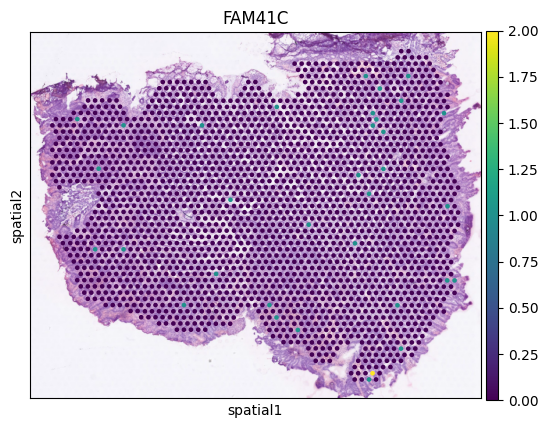

In [25]:
# Plot spatial expression map for a specific gene (example: FAM41C)
if GENE is not None:
    os.makedirs("figures", exist_ok=True)
    sc.pl.spatial(adata, color=GENE, save="_FAM41C.st_plot.png")


In [152]:
# Create an interactive dropdown for visualizing gene expression spatially
gene_dropdown = widgets.Dropdown(
    options=list(adata.var_names),   # all available gene names
    value=adata.var_names[0],        # default selected gene
    description='Gene:',
    layout=widgets.Layout(width='400px')
)

# Function to plot spatial expression of the selected gene
def plot_gene(gene):
    plt.close('all')
    sc.pl.spatial(adata, color=gene, spot_size=1, show=True)

# Link dropdown selection with plotting function
widgets.interact(plot_gene, gene=gene_dropdown)


interactive(children=(Dropdown(description='Gene:', layout=Layout(width='400px'), options=('MIR1302-2HG', 'FAM…

<function __main__.plot_gene(gene)>